In [ ]:

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


sns.set(style='whitegrid')

In [ ]:
# LOAD RESULTS & DATA 

processed_dir = '../data/processed'
model_dir = '../models'

# Load the results dictionary
with open(f'{processed_dir}/model_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Load the feature names
with open(f'{processed_dir}/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

# Load the test data (for plotting curves)
X_test_processed = np.load(f'{processed_dir}/X_test_processed.npy')
y_test = pd.read_csv(f'{processed_dir}/y_test.csv').squeeze()

# Load trained models 
models = {}
for name in ['LogisticRegression', 'RandomForest', 'LightGBM']:
    with open(f'{model_dir}/{name}.pkl', 'rb') as f:
        models[name] = pickle.load(f)

print("Successfully loaded all results, data, and models.")

Successfully loaded all results, data, and models.


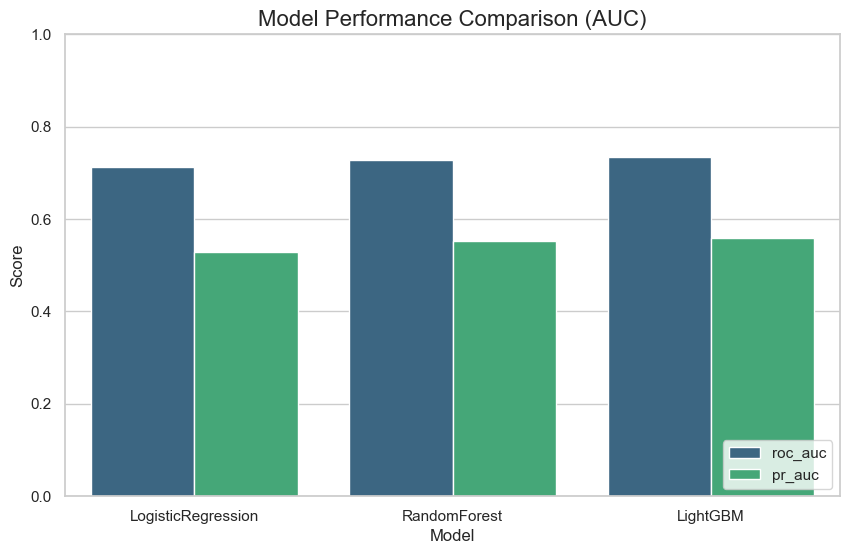

Model Performance Summary:
                Model  accuracy   roc_auc    pr_auc
0  LogisticRegression  0.734375  0.713389  0.528289
1        RandomForest  0.739062  0.726945  0.552996
2            LightGBM    0.7427  0.733675  0.559676


In [ ]:
# MODEL PERFORMANCE COMPARISON (Bar Chart)

# Convert results dict to a DataFrame for easy plotting
results_df = pd.DataFrame(results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})

# Melt the DataFrame to "long" format for seaborn
results_long = results_df.melt(
    id_vars='Model', 
    value_vars=['roc_auc', 'pr_auc'], 
    var_name='Metric', 
    value_name='Score'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Model', 
    y='Score', 
    hue='Metric', 
    data=results_long,
    palette='viridis'
)
plt.title('Model Performance Comparison (AUC)', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.savefig('../report/figures/model_comparison.png') 
plt.show()

print("Model Performance Summary:")
print(results_df[['Model', 'accuracy', 'roc_auc', 'pr_auc']])

c:\Users\vidun\OneDrive\Desktop\i_Projects\DimensiaRiskAi\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


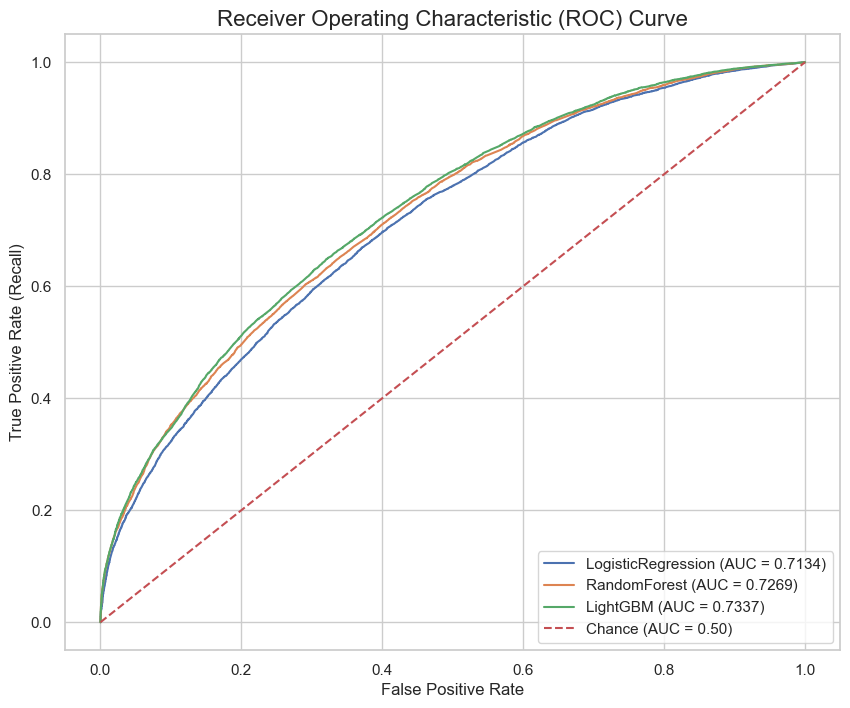

In [ ]:
# PLOT ROC CURVES 

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Get probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot the "random guess" line
plt.plot([0, 1], [0, 1], 'r--', label='Chance (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.savefig('../report/figures/roc_curve_comparison.png') # Save for the report
plt.show()

c:\Users\vidun\OneDrive\Desktop\i_Projects\DimensiaRiskAi\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


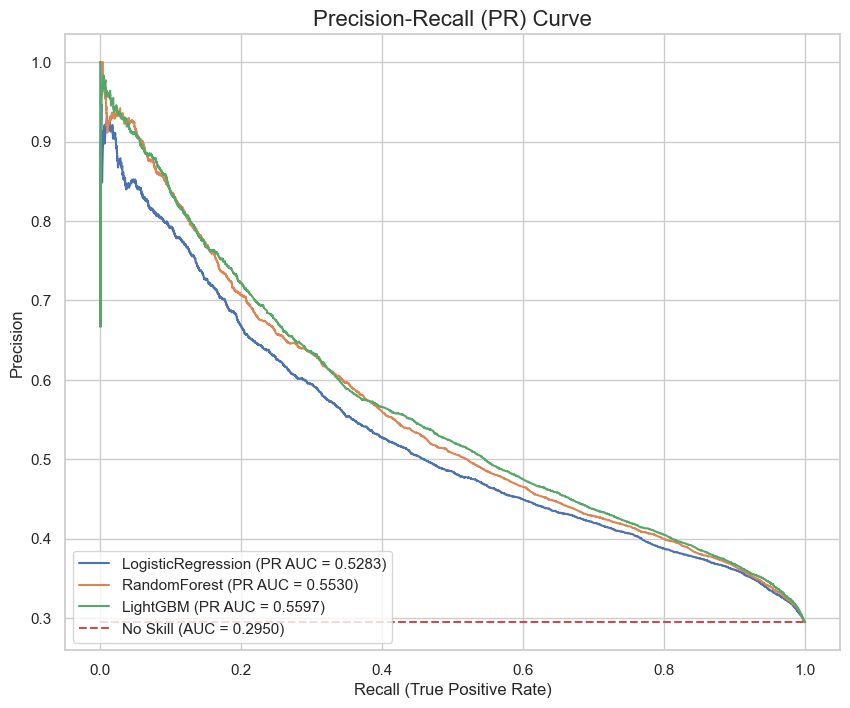

In [ ]:
# PLOT PRECISION-RECALL CURVES 

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Get probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    
    # Calculate PR curve points
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    # Plot
    plt.plot(recall, precision, label=f'{name} (PR AUC = {pr_auc:.4f})')

# Plot the "no skill" line (based on prevalence of the positive class)
no_skill = y_test.mean()
plt.plot([0, 1], [no_skill, no_skill], 'r--', label=f'No Skill (AUC = {no_skill:.4f})')

plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve', fontsize=16)
plt.legend(loc='lower left')
plt.savefig('../report/figures/pr_curve_comparison.png') # Save for the report
plt.show()

C:\Users\vidun\AppData\Local\Temp\ipykernel_1748\2488238418.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


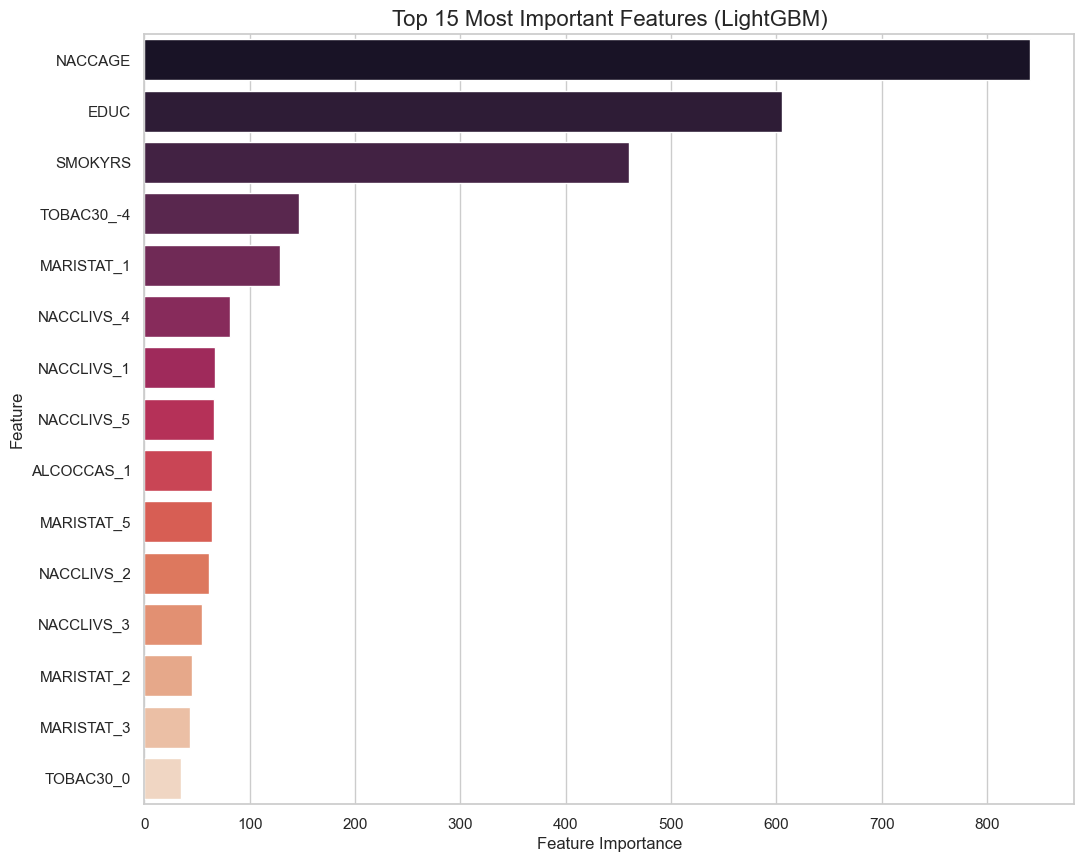

Top 15 Features:
       Feature  Importance
0      NACCAGE         841
1         EDUC         605
2      SMOKYRS         460
3   TOBAC30_-4         147
19  MARISTAT_1         129
29  NACCLIVS_4          81
26  NACCLIVS_1          67
30  NACCLIVS_5          66
9   ALCOCCAS_1          64
23  MARISTAT_5          64
27  NACCLIVS_2          61
28  NACCLIVS_3          55
20  MARISTAT_2          45
21  MARISTAT_3          43
4    TOBAC30_0          35


In [ ]:
# EXPLAINABILITY & INSIGHTS

# We'll use LightGBM as it's the best performer
model_to_explain = models['LightGBM']
importances = model_to_explain.feature_importances_

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Get the Top 15 features
top_15_features = importance_df.head(15)

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_15_features,
    palette='rocket'
)
plt.title('Top 15 Most Important Features (LightGBM)', fontsize=16)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.savefig('../report/figures/feature_importance.png') 
plt.show()

print("Top 15 Features:")
print(top_15_features)